Каждый из нас писал в школе и университете изложения, сочинения, рефераты. А значит, в каждом из нас живет великий русский писатель.
В этой работе будем раскрывать свои таланты, находить себя в ряду таких гениев, как Пушкин, Гоголь, Грибоедов

В этой работе
- скачаем корпус текстов 20-ми русских писателей. Каждый текст разобьем на обучающую и тестовую выборки.
- разработаем и обучим нейронную сеть определяющию авторство фрагментов текста (по тестовой выборке)
- скачаем СВОЕ сочинение (или чье-нибудь - есть в архиве). Сделаем из него проверочную выборку
- предложим нейронке предсказать автора сочинения (по проверочной выборке)
- объявим себя великим писателем, например, Гончаровым

Ссылка на архив: https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip

В работе рекомендуется пользоваться материалами из ноутбука практического занятия "Рекуррентные и одномерные сверточные нейронные сети". Допускается выбрать лучший вариант нейронки и адаптировать ее структуру, параметры обучения и формирования датасетов под свои *нужды*

## **Загрузка библиотек**

In [ ]:
import numpy as np
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gdown
import os
import time
import re
import matplotlib.pyplot as plt
from IPython.display import display
from tensorflow.keras.optimizers import Adam, RMSprop
%matplotlib inline

## **Загрузка данных**

In [ ]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip', None, quiet=True)

!unzip -qo 20writers.zip -d writers/

!ls writers

Беляев.txt    Гончаров.txt     Каверин.txt    Лесков.txt     Толстой.txt
Булгаков.txt  Горький.txt      Катаев.txt     Носов.txt      Тургенев.txt
Васильев.txt  Грибоедов.txt    Куприн.txt     Пастернак.txt  Чехов.txt
Гоголь.txt    Достоевский.txt  Лермонтов.txt  Пушкин.txt     Шолохов.txt


In [ ]:
FILE_DIR  = 'writers/'

CLASS_LIST = []
text_train = []
text_test = []

split_coef = 0.8
file_list = os.listdir(FILE_DIR)

for file_name in file_list:
    m = file_name.split('.')
    class_name = m[0]
    ext = m[1]

    if ext=='txt':
        if class_name not in CLASS_LIST:
            print(f'Добавление класса "{class_name}"')
            CLASS_LIST.append(class_name)

        cls = CLASS_LIST.index(class_name)
        print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}"')

        with open(f'{FILE_DIR}/{file_name}', 'r') as f:
            text = f.read()
            text = text.replace('\n', ' ').split(' ')
            text_len=len(text)
            text_train.append(' '.join(text[:int(text_len*split_coef)]))
            text_test.append(' '.join(text[int(text_len*split_coef):]))


Добавление класса "Чехов"
Добавление файла "Чехов.txt" в класс "Чехов"
Добавление класса "Горький"
Добавление файла "Горький.txt" в класс "Горький"
Добавление класса "Носов"
Добавление файла "Носов.txt" в класс "Носов"
Добавление класса "Толстой"
Добавление файла "Толстой.txt" в класс "Толстой"
Добавление класса "Лесков"
Добавление файла "Лесков.txt" в класс "Лесков"
Добавление класса "Куприн"
Добавление файла "Куприн.txt" в класс "Куприн"
Добавление класса "Гоголь"
Добавление файла "Гоголь.txt" в класс "Гоголь"
Добавление класса "Гончаров"
Добавление файла "Гончаров.txt" в класс "Гончаров"
Добавление класса "Беляев"
Добавление файла "Беляев.txt" в класс "Беляев"
Добавление класса "Катаев"
Добавление файла "Катаев.txt" в класс "Катаев"
Добавление класса "Каверин"
Добавление файла "Каверин.txt" в класс "Каверин"
Добавление класса "Грибоедов"
Добавление файла "Грибоедов.txt" в класс "Грибоедов"
Добавление класса "Достоевский"
Добавление файла "Достоевский.txt" в класс "Достоевский"
Добав

In [ ]:
CLASS_COUNT = len(CLASS_LIST)
print(CLASS_COUNT)

20


In [ ]:
for cls in range(CLASS_COUNT):             # Запустим цикл по числу классов
    print(f'Класс: {CLASS_LIST[cls]}')     # Выведем имя класса
    print(f'  train: {text_train[cls]}')   # Выведем фрагмент обучающей выборки
    print(f'  test : {text_test[cls]}')    # Выведем фрагмент тестовой выборки
    print()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
class timex:
    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

## **Подготовка данных**

In [ ]:
def split_sequence(sequence, win_size, hop):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

def vectorize_sequence(seq_list, win_size, hop):
    class_count = len(seq_list)
    x, y = [], []

    for cls in range(class_count):
        vectors = split_sequence(seq_list[cls], win_size, hop)
        x += vectors
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    return np.array(x), np.array(y)

In [ ]:
VOCAB_SIZE = 30000
WIN_SIZE   = 1000
WIN_HOP    = 100

In [ ]:
with timex():
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    tokenizer.fit_on_texts(text_test)
    items = list(tokenizer.word_index.items())

Время обработки: 13.87 с


In [ ]:
with timex():
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    print("Фрагмент обучающего текста:")
    print("В виде оригинального текста:              ", text_test[1][:101])
    print("Он же в виде последовательности индексов: ", seq_test[1][:20])

Фрагмент обучающего текста:
В виде оригинального текста:               выговаривая слова, он изливался густою струёй, и от каждого слова веяло местью. Уж я ему это выплачу…
Он же в виде последовательности индексов:  [14202, 177, 9, 1, 25068, 1, 2, 25, 1214, 177, 8582, 1, 91, 8, 37, 16, 1, 3915, 4527, 1]
Время обработки: 11.27 с


In [ ]:
with timex():
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

(69031, 1000) (69031, 20)
(17273, 1000) (17273, 20)
Время обработки: 9.39 с


## **Сервисные функции**

In [ ]:
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer = Adam(0.00001),
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    display(plot_model(model, dpi=60, show_shapes=True))

    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    cm = np.around(cm, cm_round)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    for cls in range(len(class_labels)):
        cls_pred = np.argmax(cm[cls])
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

## **Создание и обучение модели**

In [ ]:
model_LSTM_6 = Sequential()
model_LSTM_6.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_LSTM_6.add(SpatialDropout1D(0.4))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(GRU(16, return_sequences=True, reset_after=True))
model_LSTM_6.add(GRU(16, reset_after=True))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(Dense(200, activation='relu'))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
model_LSTM_6.add(Dense(CLASS_COUNT, activation='softmax'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          1500000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 50)         0         
 ropout1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 1000, 50)         200       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 16)         3776      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1000, 16)         1600      
 nal)                                                   

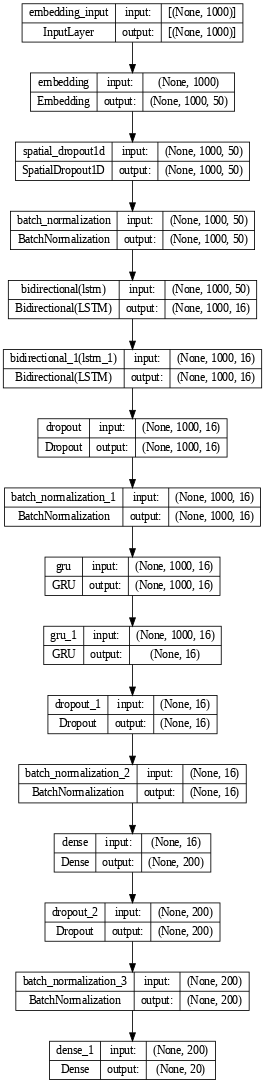

Epoch 1/100
135/135 [==============================] - 65s 356ms/step - loss: 3.1992 - accuracy: 0.0798 - val_loss: 2.9067 - val_accuracy: 0.1224
Epoch 2/100
135/135 [==============================] - 41s 301ms/step - loss: 2.8311 - accuracy: 0.1345 - val_loss: 3.0060 - val_accuracy: 0.1544
Epoch 3/100
135/135 [==============================] - 36s 267ms/step - loss: 2.5426 - accuracy: 0.1857 - val_loss: 2.5697 - val_accuracy: 0.2068
Epoch 4/100
135/135 [==============================] - 34s 255ms/step - loss: 2.1741 - accuracy: 0.2819 - val_loss: 2.3173 - val_accuracy: 0.2856
Epoch 5/100
135/135 [==============================] - 35s 263ms/step - loss: 1.4624 - accuracy: 0.4792 - val_loss: 1.8777 - val_accuracy: 0.4171
Epoch 6/100
135/135 [==============================] - 33s 247ms/step - loss: 0.8202 - accuracy: 0.7058 - val_loss: 1.0749 - val_accuracy: 0.6631
Epoch 7/100
135/135 [==============================] - 32s 238ms/step - loss: 0.4173 - accuracy: 0.8644 - val_loss: 1.0613 -

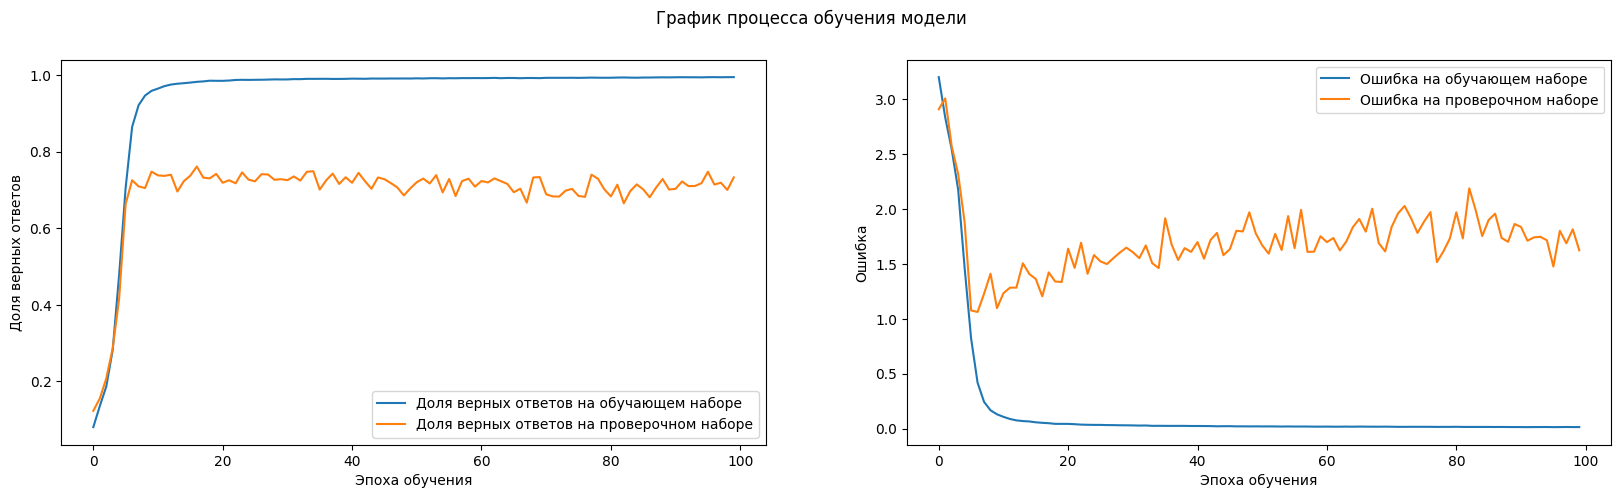

540/540 [==============================] - 36s 64ms/step


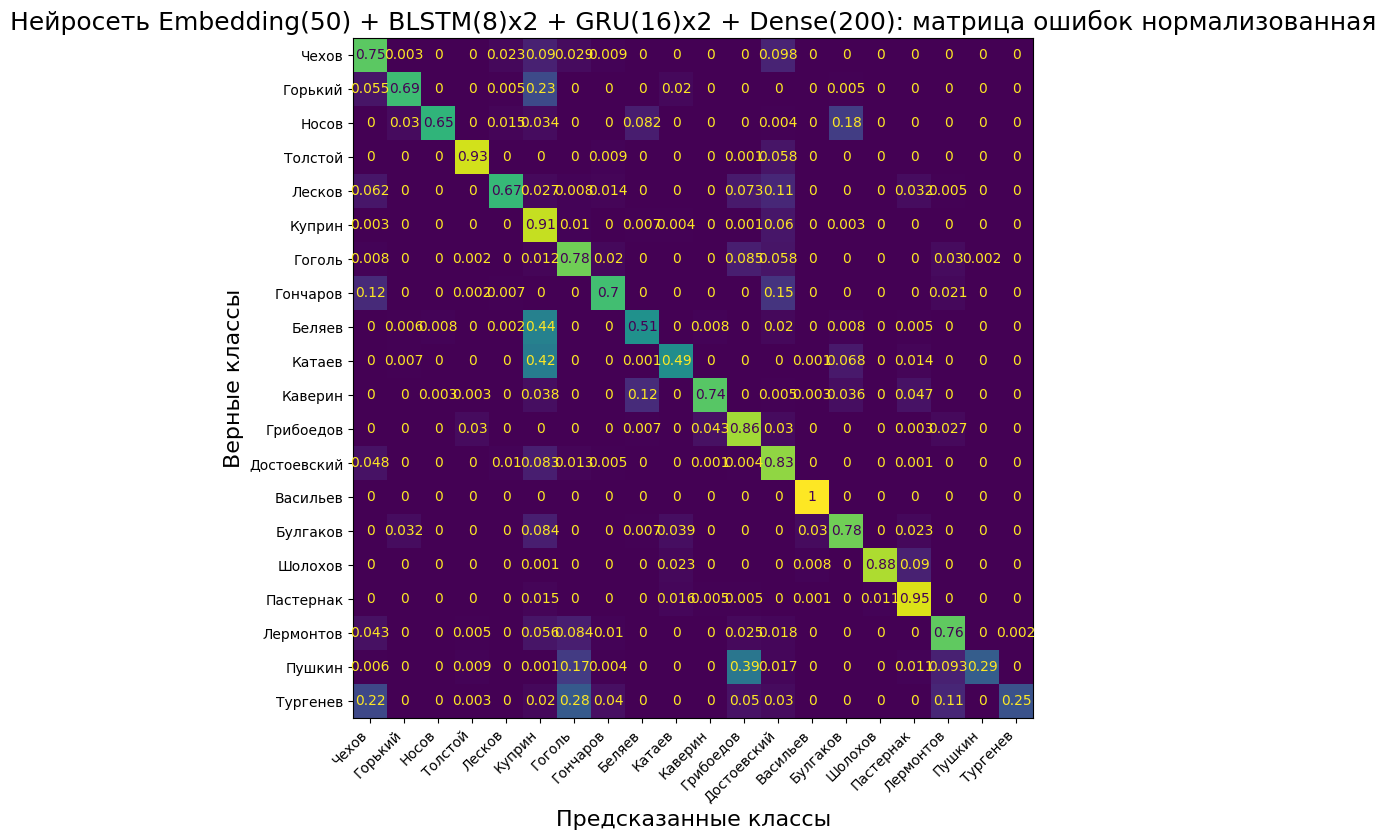

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)
Класс: Чехов                 75% сеть отнесла к классу Чехов                - ВЕРНО :-)
Класс: Горький               69% сеть отнесла к классу Горький              - ВЕРНО :-)
Класс: Носов                 65% сеть отнесла к классу Носов                - ВЕРНО :-)
Класс: Толстой               93% сеть отнесла к классу Толстой              - ВЕРНО :-)
Класс: Лесков                67% сеть отнесла к классу Лесков               - ВЕРНО :-)
Класс: Куприн                91% сеть отнесла к классу Куприн               - ВЕРНО :-)
Класс: Гоголь                78% сеть отнесла к классу Гоголь               - ВЕРНО :-)
Класс: Гончаров              70% сеть отнесла к классу Гончаров             - ВЕРНО :-)
Класс: Беляев                51% сеть отнесла к классу Беляев               - ВЕРНО :-)
Класс: Катаев                49% сеть отнесл

In [ ]:
compile_train_eval_model(model_LSTM_6,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer=RMSprop(0.001),
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)')

Подготовка тестовых данных. В качестве примера юыл взят "Маленький Принц" Экзюпери

In [ ]:
little_prince = ['''Когда мне было шесть лет, в книге под названием «Правдивые истории», где рассказывалось про девственные леса, я увидел однажды удивительную картинку. На картинке огромная змея — удав — глотала хищного зверя. Вот как это было нарисовано: В книге говорилось: «Удав заглатывает свою жертву целиком, не жуя. После этого он уже не может шевельнуться и спит полгода подряд, пока не переварит пищу». Я много раздумывал о полной приключений жизни джунглей и тоже нарисовал цветным карандашом свою первую картинку. Это был мой рисунок №1. Вот что я нарисовал: Я показал мое творение взрослым и спросил, не страшно ли им.— Разве шляпа страшная? — возразили мне. А это была совсем не шляпа. Это был удав, который проглотил слона. Тогда я нарисовал удава изнутри, чтобы взрослым было понятнее. Им ведь всегда нужно все объяснять. Это мой рисунок №2: Взрослые посоветовали мне не рисовать змей ни снаружи, ни изнутри, а побольше интересоваться географией, историей, арифметикой и правописанием. Вот как случилось, что шести лет я отказался от блестящей карьеры художника. Потерпев неудачу с рисунками №1 и №2, я утратил веру в себя. Взрослые никогда ничего не понимают сами, а для детей очень утомительно без конца им все объяснять и растолковывать. Итак, мне пришлось выбирать другую профессию, и я выучился на летчика. Облетел я чуть ли не весь свет. И география, по правде сказать, мне очень пригодилась. Я умел с первого взгляда отличить Китай от Аризоны. Это очень полезно, если ночью собьешься с пути. На своем веку я много встречал разных серьезных людей. Я долго жил среди взрослых. Я видел их совсем близко. И от этого, признаться, не стал думать о них лучше. Когда я встречал взрослого, который казался мне разумней и понятливей других, я показывал ему свой рисунок №1 — я его сохранил и всегда носил с собою. Я хотел знать, вправду ли этот человек что-то понимает. Но все они отвечали мне: «Это шляпа».  И я уже не говорил с ними ни об удавах, ни о джунглях, ни о звездах. Я применялся к их понятиям. Я говорил с ними об игре в бридж и гольф, о политике и о галстуках. И взрослые были очень довольны, что познакомились с таким здравомыслящим человеком.''']

In [ ]:
seq_train = tokenizer.texts_to_sequences(little_prince)

In [ ]:
print("Фрагмент текста:")
print("В виде оригинального текста:              ", little_prince[:20])
print("Он же в виде последовательности индексов: ", seq_train[:20])

Фрагмент текста:
В виде оригинального текста:               ['Когда мне было шесть лет, в книге под названием «Правдивые истории», где рассказывалось про девственные леса, я увидел однажды удивительную картинку. На картинке огромная змея — удав — глотала хищного зверя. Вот как это было нарисовано: В книге говорилось: «Удав заглатывает свою жертву целиком, не жуя. После этого он уже не может шевельнуться и спит полгода подряд, пока не переварит пищу». Я много раздумывал о полной приключений жизни джунглей и тоже нарисовал цветным карандашом свою первую картинку. Это был мой рисунок №1. Вот что я нарисовал: Я показал мое творение взрослым и спросил, не страшно ли им.— Разве шляпа страшная? — возразили мне. А это была совсем не шляпа. Это был удав, который проглотил слона. Тогда я нарисовал удава изнутри, чтобы взрослым было понятнее. Им ведь всегда нужно все объяснять. Это мой рисунок №2: Взрослые посоветовали мне не рисовать змей ни снаружи, ни изнутри, а побольше интересоваться географ

In [ ]:
seq_train, _ = vectorize_sequence(seq_train, 100, 10)

In [ ]:
print(seq_train.shape)

(26, 100)


In [ ]:
y_pred = model_LSTM_6.predict(seq_train)
print(y_pred)

1/1 [==============================] - 2s 2s/step
[[3.01886845e-04 2.73285696e-05 2.86325786e-07 2.63559173e-07
  1.10808651e-05 9.66238379e-01 1.09216850e-02 9.94353904e-05
  4.56703827e-03 2.96304701e-03 1.18825767e-04 2.14191223e-03
  1.16856657e-02 9.04258122e-05 9.14156226e-06 6.46721276e-07
  8.12761195e-04 7.43118744e-06 2.18002356e-06 6.74534590e-07]
 [3.77967546e-04 2.11040151e-05 2.97176655e-07 4.74534289e-07
  2.01055445e-05 9.53298271e-01 1.08880661e-02 1.64741839e-04
  5.22485841e-03 3.36604379e-03 1.22749363e-04 2.34365324e-03
  2.31314041e-02 1.03077873e-04 9.39747952e-06 7.83819928e-07
  9.14802717e-04 8.69305313e-06 2.89618288e-06 7.25523535e-07]
 [2.16475368e-04 1.89787570e-05 2.40608898e-07 2.71695086e-07
  1.02343283e-05 9.71656382e-01 8.57014395e-03 8.69667274e-05
  3.93066416e-03 2.65774410e-03 1.31896319e-04 2.01532897e-03
  9.74790659e-03 8.82295863e-05 6.74063176e-06 6.71797409e-07
  8.52478552e-04 6.16593798e-06 1.99991359e-06 4.57795835e-07]
 [2.91103002e-04 

In [ ]:
r = np.argmax(y_pred, axis=1)
unique, counts = np.unique(r, return_counts=True)
counts = counts/y_pred.shape[0]*100
print(unique, counts)

for i in range(len(unique)):
  print('{:10s} - {:<.2f}%'.format(CLASS_LIST[unique[i]],counts[i]))

[5] [100.]
Куприн     - 100.00%
